# Modèle d'entraînement et de test

## Splitting du dataset

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
loan_df=pd.read_csv("../data/Loan_clean.csv")

In [3]:
# Séparation des features et des targets
X = loan_df.drop("Loan_Status", axis=1)
y = loan_df["Loan_Status"]

In [4]:
#Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) #80% train, 20% test(0.2)


print("train :", X_train.shape)
print("test :", X_test.shape)

train : (491, 15)
test : (123, 15)


## Preprocessing

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

Variable catégorielle  --> Encodage en numérique + Mise à l'échelle des valeurs numériques

In [6]:
vlr_numerique = ["ApplicantIncome", "CoapplicantIncome", "LoanAmount_log", "InterestRate"]
vlr_categorie = ["Gender", "Married", "Dependents","Education", "Self_Employed", "Property_Area"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), vlr_numerique),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), vlr_categorie)
    ]
)

## Entraînement des modèles

In [49]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib

## Pipeline pour chaque modèle

In [50]:
models = {
    "Logistic Regression": ImbPipeline(steps=[
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("model", LogisticRegression(max_iter=1000, random_state=42))
    ]),
    "Decision Tree": ImbPipeline(steps=[
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("model", DecisionTreeClassifier(random_state=42))
    ]),
    "Random Forest": ImbPipeline(steps=[
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("model", RandomForestClassifier(n_estimators=300, random_state=42, class_weight="balanced"))
    ]),
    "AdaBoost": ImbPipeline(steps=[
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("model", AdaBoostClassifier(n_estimators=300, random_state=42))
    ]),
    "LDA": ImbPipeline(steps=[
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("model", LinearDiscriminantAnalysis(solver="lsqr", shrinkage="auto"))
    ]),
    "XGBoost": ImbPipeline(steps=[
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("model", XGBClassifier(
            n_estimators=500,
            max_depth=4,
            learning_rate=0.05,
            subsample=0.9,
            colsample_bytree=0.9,
            reg_lambda=1.0,
            random_state=42,
            n_jobs=-1,
            objective="binary:logistic",
            eval_metric="logloss"
        ))
    ])
}

### Comparaison des performances

In [51]:
results = {}
for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1] if hasattr(pipe, "predict_proba") else None
    
    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall": recall_score(y_test, y_pred, zero_division=0),
        "F1": f1_score(y_test, y_pred, zero_division=0),
        "ROC-AUC": roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan
    }

c:\Users\pemab\Documents\Projet_fin_etude\Prediction_approbation_pret\venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [52]:

results_df = pd.DataFrame(results).T
display(results_df)

,Accuracy,Precision,Recall,F1,ROC-AUC
Logistic Regression,0.560976,0.738462,0.564706,0.640000,0.629412
Decision Tree,0.455285,0.618421,0.552941,0.583851,0.394892
Random Forest,0.658537,0.712871,0.847059,0.774194,0.538854
AdaBoost,0.609756,0.703297,0.752941,0.727273,0.476471
LDA,0.528455,0.714286,0.529412,0.608108,0.613003
XGBoost,0.601626,0.704545,0.729412,0.716763,0.501238


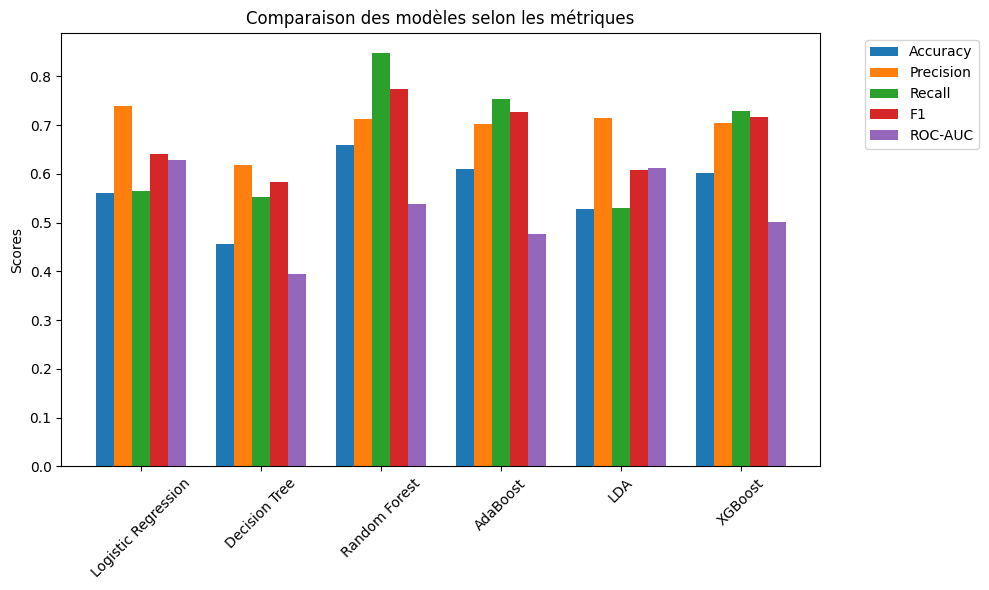

In [53]:
results_df = pd.DataFrame(results).T
models_list = results_df.index  # model names
x = np.arange(len(models_list))
width = 0.15

fig, ax = plt.subplots(figsize=(10, 6))
for i, metric in enumerate(results_df.columns):
    ax.bar(x + i * width, results_df[metric], width, label=metric)

ax.set_xticks(x + width * 2)
ax.set_xticklabels(models_list, rotation=45)
ax.set_ylabel("Scores")
ax.set_title("Comparaison des modèles selon les métriques")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # legend on the right

plt.tight_layout()
plt.show()

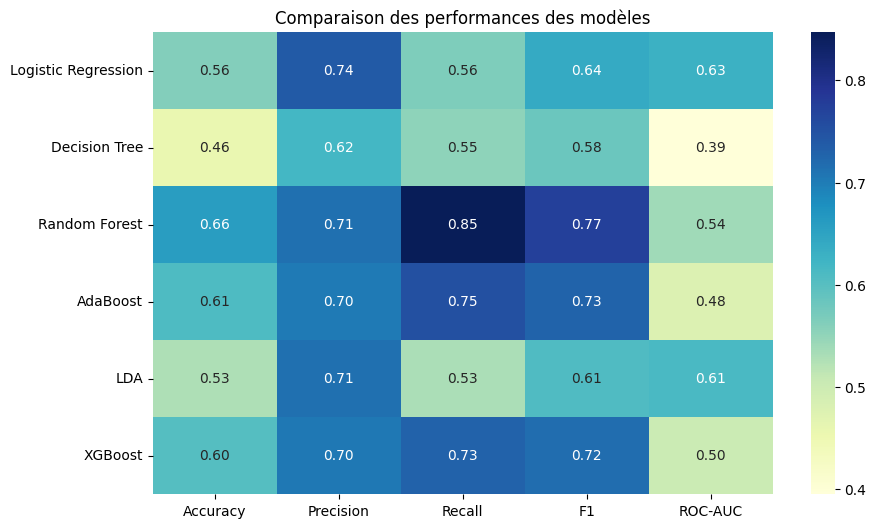

In [54]:
# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(results_df, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Comparaison des performances des modèles")
plt.show()

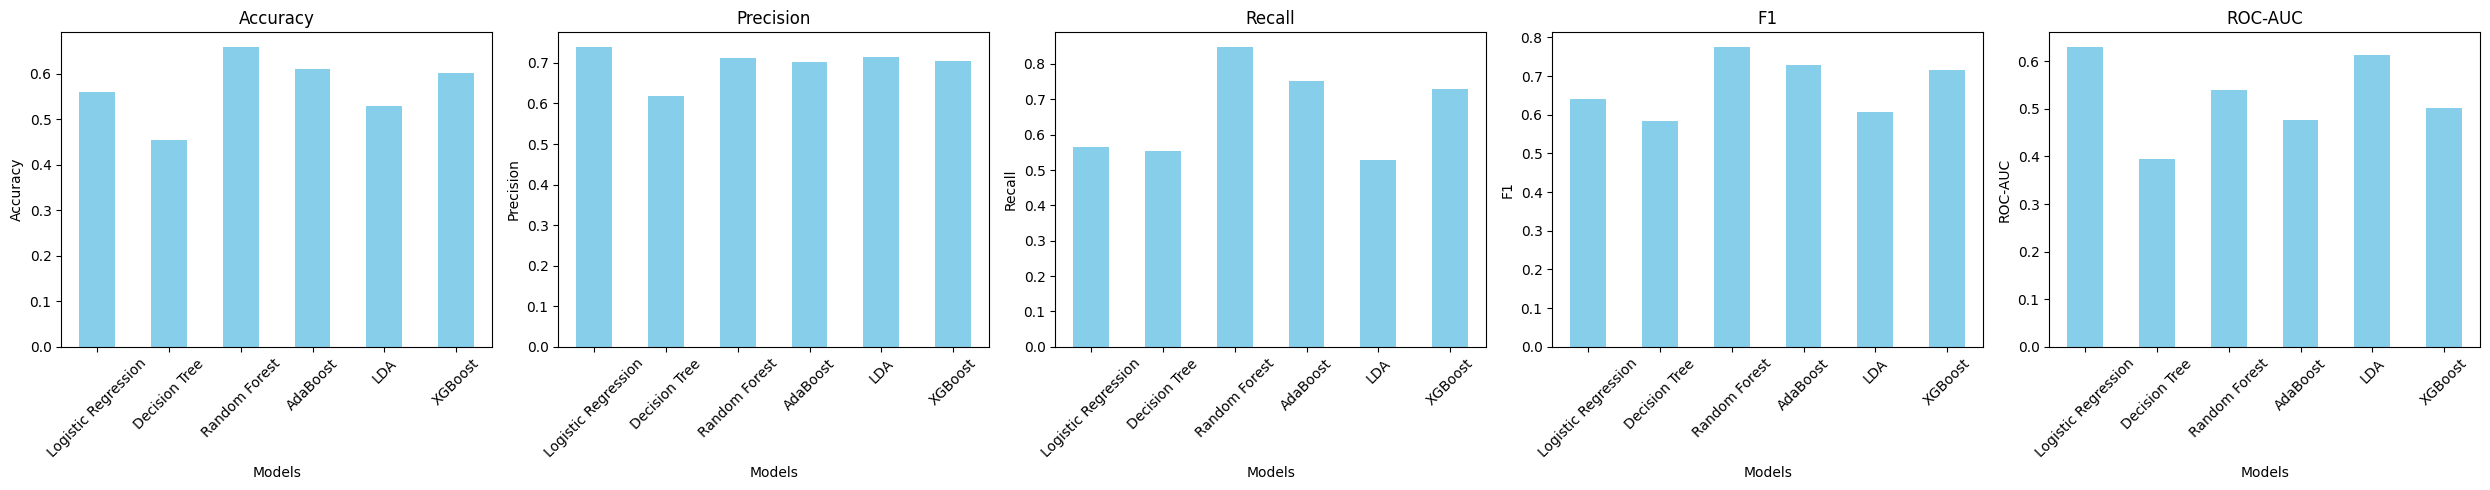

In [55]:
# Plot each metric separately for comparison across models

results_df = pd.DataFrame(results).T
metrics = results_df.columns
n_metrics = len(metrics)

fig, axes = plt.subplots(1, n_metrics, figsize=(5 * n_metrics, 5))

for i, metric in enumerate(metrics):
    results_df[metric].plot(kind='bar', ax=axes[i], title=metric, color='skyblue')
    axes[i].set_xlabel('Models')
    axes[i].set_ylabel(metric)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [56]:
# Calculer la moyenne des valeurs des métriques pour chaque modèle et trier dans l'ordre croissant
results_df = pd.DataFrame(results).T
average_metrics = results_df.mean(axis=1).sort_values(ascending=False)
print(average_metrics)

Random Forest          0.706303
AdaBoost               0.653947
XGBoost                0.650717
Logistic Regression    0.626711
LDA                    0.598653
Decision Tree          0.521078
dtype: float64


### Choix du meilleur modèle

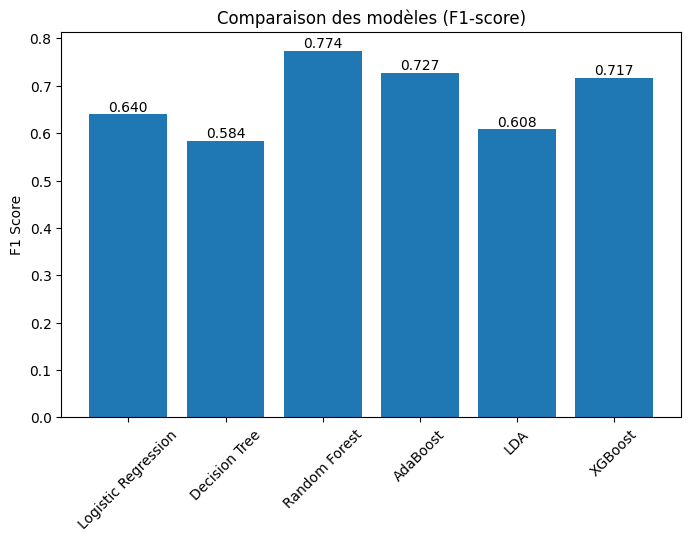

In [57]:
plt.figure(figsize=(8,5))
bars = plt.bar(results_df.index, results_df["F1"])
plt.xticks(rotation=45)
plt.ylabel("F1 Score")
plt.title("Comparaison des modèles (F1-score)")
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.3f}', ha='center', va='bottom')
plt.show()

In [58]:
sorted_df = results_df.sort_values('F1', ascending=False)
f1_max = sorted_df['F1'].iloc[0]
candidats = sorted_df[sorted_df['F1'] >= f1_max - 0.01]
print("\nLes modèles les plus proches du meilleur F1-score avec un écart <= 0.0.1 :")
display(candidats[['F1', 'ROC-AUC']])

# 3. Parmi les candidats, choisir celui avec le ROC-AUC le plus élevé
final_model = candidats.sort_values('ROC-AUC', ascending=False).iloc[0]
final_name = candidats.sort_values('ROC-AUC', ascending=False).index[0]



Les modèles les plus proches du meilleur F1-score avec un écart <= 0.0.1 :


,F1,ROC-AUC
Random Forest,0.774194,0.538854


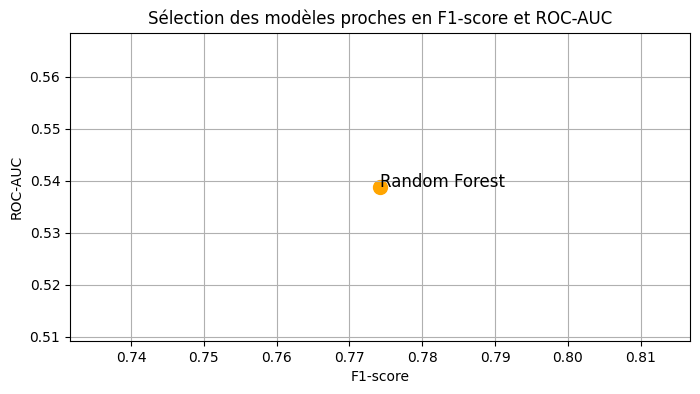

In [59]:
plt.figure(figsize=(8,4))
plt.scatter(candidats['F1'], candidats['ROC-AUC'], color='orange', s=100)
for idx in candidats.index:
    plt.text(candidats.loc[idx,'F1'], candidats.loc[idx,'ROC-AUC'], idx, fontsize=12)
plt.xlabel("F1-score")
plt.ylabel("ROC-AUC")
plt.title("Sélection des modèles proches en F1-score et ROC-AUC")
plt.grid(True)
plt.show()

In [60]:
print("Meilleur modèle :", final_name)
print("Détails du modèle :\n", final_model)

Meilleur modèle : Random Forest
Détails du modèle :
 Accuracy     0.658537
Precision    0.712871
Recall       0.847059
F1           0.774194
ROC-AUC      0.538854
Name: Random Forest, dtype: float64


In [61]:
best_model = models[final_name]
best_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['ApplicantIncome',
                                                   'CoapplicantIncome',
                                                   'LoanAmount_log',
                                                   'InterestRate']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['Gender', 'Married',
                                                   'Dependents', 'Education',
                                                   'Self_Employed',
                                                   'Property_Area'])])),
                ('smote', SMOTE(random_state=42)),
                ('model',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=300, random_state=42))])

#### Sauvegarde du modèle

In [62]:
joblib.dump(best_model, "../models/best_model.pkl")

['../models/best_model.pkl']

#### Evaluation finale sur les données de test

In [63]:
y_pred = models[final_name].predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.41      0.24      0.30        38
           1       0.71      0.85      0.77        85

    accuracy                           0.66       123
   macro avg       0.56      0.54      0.54       123
weighted avg       0.62      0.66      0.63       123

[[ 9 29]
 [13 72]]


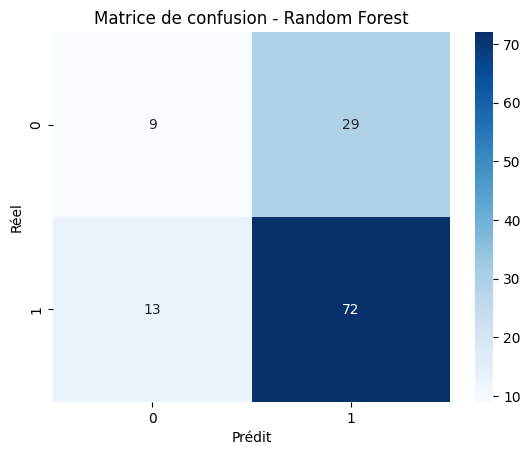

In [64]:
cm_best = confusion_matrix(y_test, y_pred)

sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues',)
plt.title(f"Matrice de confusion - {final_name}")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.show()